# PPO

Proximal Policy Optimization

### Policy gradient methods

Policy gradient methods are group of RL methods that attempt to find a policy gradient, then using a gradient ascent algorithm. Generally, this involves alternating between sampling and optimization. Many samples are taken to construct a policy gradient, this policy gets optimized, then more samples are taken. In reality, there exists a large variety of policy gradient methods, each seeking to do the same thing with a distinct strategy: Utilize gradient ascent on the policy gradient.

### Actor-critic structure

PPO uses an actor-critic structue. This means that it uses a dynamic involving two neural networks, were one network is an actor network (also known as the policy network), that converts the observations into actions, while the other network is the critic network (also known as the value network), which evaluates the performance of the actor network by recieving the observations as a input and outputing a discounted return. In this way, both the actor and the critic are learning during training, allowing for more complex value estimations.  

While actually running the agent, only the actor network is used. The critic network only exists for use during the training process.

### How does PPO do this?

From Proximal Polyicy Optimization paper by OpenAI: https://doi.org/10.48550/arXiv.1707.06347

![Alt text](PPODescription.png)

### Why PPO?

PPO has been shown to excel at continous environments, which happen to be the environments that we face in robotics. It strikes a great balance between reliability and sample efficiency, outpreforming Deep Q-Networks in a variety of scenarios. Because of this, PPO is available in many of the frameworks included in IsaacLab, which we will be using next.

#### Dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing


from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

#### Define hyperparameters

In [2]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
print(device)
num_cells = 128  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

# Data collection parameters

frames_per_batch = 1000
total_frames = 50_000

# PPO parameters
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

cuda:0


#### Define environment

In [3]:
base_env = GymEnv("InvertedPendulum-v5", device=device, render_mode="human")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


#### Normalization

In [4]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations, making observations somewhat fit a gaussian distribution is preferable
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(),
        StepCounter(),
    ),
)

# Set the parameters for the ObservationNorm() transform. Defining how the observation is normalized
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)
print("normalization constant shape:", env.transform[0].loc.shape)

check_env_specs(env)

normalization constant shape: torch.Size([4])
2025-11-05 18:06:02,881 [torchrl][INFO]    check_env_specs succeeded! [END]


In [5]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: Composite(
    observation: UnboundedContinuous(
        shape=torch.Size([4]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([4]), device=cuda:0, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([4]), device=cuda:0, dtype=torch.float32, contiguous=True)),
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedDiscrete(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True)),
        device=cuda:0,
        dtype=torch.int64,
        domain=discrete),
    device=cuda:0,
    shape=torch.Size([]),
    data_cls=None)
reward_spec: UnboundedContinuous(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float

In [6]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                observation: Tensor(shape=torch.Size([3, 4]), device=cuda:0, dtype=torch.float32, is_shared=True),
                reward: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.int64, is_shared=True),
                terminated: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                truncated: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
            batch_size=torch.Size([3]),
 

#### Defining the policy network

The policy network is what is considered as the actor in the PPO algorith. Here, the neural network produces two outputs of the size of the action space. This includes a location output and a scale output. The scale output is fixed to be positive. To fit both of these outputs in the neural network, the last transformation maps to a size of 2 times the action space size. The other tansformation are simply the number of cells, or neurons in the neural network, which were defined earlier,

In [7]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

#### Policy module

The policy module is necessary to define the inputs and outputs of the neural network. This is where we write the two distinct outputs. 

In [8]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

Then, the policy module is used to build a distribution out of the location and scale of the previous normal distribution. This uses a probablistic actor class. Minimum and maximum values are also set, which come from the environment's specifications.

In [9]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
       distribution_kwargs={
        "low": env.action_spec.space.low,
        "high": env.action_spec.space.high,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

### Value network

The next important component of PPO is the value network. The value network is used to evaluate the actions. It is the "critic" in our actor-critic algorithm. It will take the observations as input and output a scalar value representing the expected return from that state. In this case the value network uses the same structure as the actor network, but with different parameters and weights.

In [10]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        action_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([4]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        terminated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        truncated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_sha

Replay buffer for stability

In [11]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

We will then use TorchRL's data collector class, which does three operations:

1. reset the environment
2. execute a step in the environment
3. repeat 

In [12]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device
)

### Loss function

For PPO to function, there needs to exist an advantage estimation, which balances bias and variance. Here, we will use TorchRL's GAE (general advantage estimator) module, which uses the value network defined previously.

Next, TorchRL's ClipPPOLoss is used to penalize certain actions according to PPO theory. For more details, check open AI's paper.

In [13]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True, device=device,
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coeff=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coeff=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

### Training loop

In [14]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

eval cumulative reward:  1000.0000 (init:  22.0000), eval step-count: 999, average reward= 1.0000 (init= 0.8250), step count (max): 999, lr policy:  0.0000: 100%|██████████| 50000/50000 [01:54<00:00, 487.27it/s]

### Results

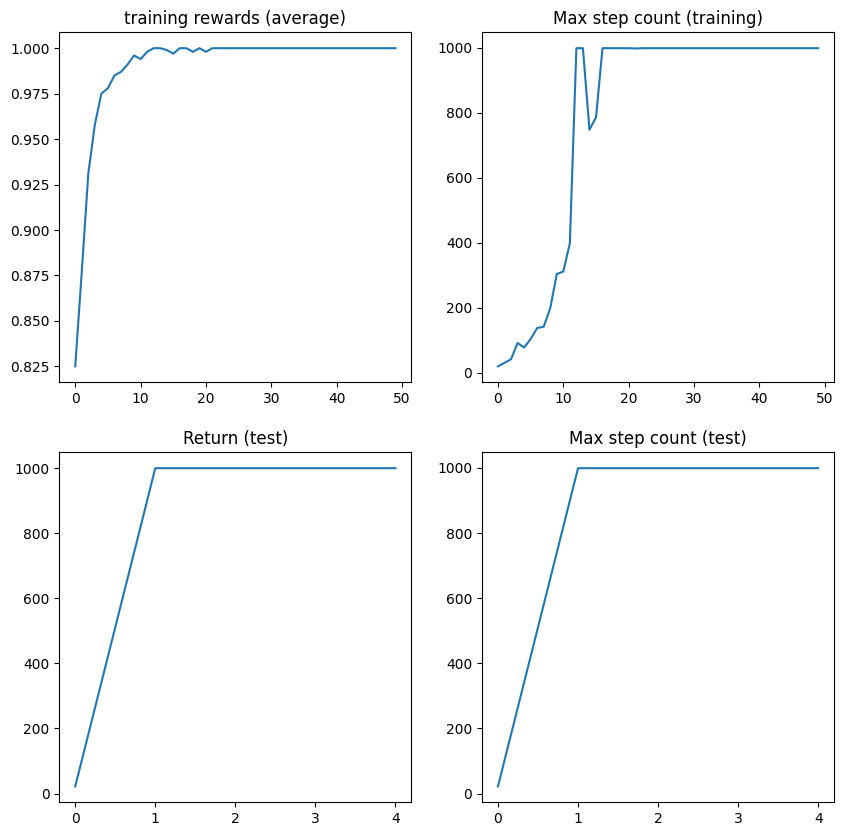

eval cumulative reward:  1000.0000 (init:  22.0000), eval step-count: 999, average reward= 1.0000 (init= 0.8250), step count (max): 999, lr policy:  0.0000: 100%|██████████| 50000/50000 [02:10<00:00, 487.27it/s]

In [15]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

#### Additional References

For more information about the code used in this section, look at Pytorch docs, primarily:

_Reinforcement Learning (PPO) with TorchRL Tutorial_ (2017). Pytorch. https://docs.pytorch.org/tutorials/intermediate/reinforcement_ppo.html#reinforcement-learning-ppo-with-torchrl-tutorial

Also look at the paper by the people at OpenAI:

Schulman, J., Wolski, F., Dhariwal, P., Radford, A., & Klimov, O. (2017). _Proximal Policy Optimization Algorithms._ https://doi.org/10.48550/arXiv.1707.06347
